In [205]:
import numpy as np
import json
from collections import defaultdict
from scipy import spatial
import matplotlib.pyplot as plt
from collections import Counter
from validate_semantics import load_wordnet_axes, get_glove_vecs, get_bert_vecs
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
ROOT = '/mnt/data0/lucy/manosphere/'
DATA = ROOT + 'data/'
GLOVE = DATA + 'glove/'
LOGS = ROOT + 'logs/'

### Axes in vector space

In [201]:
axes, axes_vocab = load_wordnet_axes()
glove_vecs = get_glove_vecs(set(), axes_vocab)

## Occupations

In [442]:
with open(LOGS + 'semantics_val/occupations/frameaxis_default.json', 'r') as infile:
    biases = json.load(infile) # {c : { pole : (bias, effect) } }
    
for c in biases: 
    print("BIAS SEPARATION", c)
    vals = []
    dims = []
    for pole in biases[c]: 
        dims.append((pole, biases[c][pole][0], biases[c][pole][2], biases[c][pole][3]))
        vals.append(biases[c][pole][0])
    sorted_dims = [x for _,x in sorted(zip(vals,dims))]
    print('1st max:', sorted_dims[-1])
    print('2nd max:', sorted_dims[-2])
    print('3rd max:', sorted_dims[-3])
    print()
    
for c in biases: 
    print("BIAS", c)
    vals = []
    dims = []
    for pole in biases[c]: 
        dims.append((pole, biases[c][pole][3]))
        vals.append(abs(biases[c][pole][3]))
    sorted_dims = [x for _,x in sorted(zip(vals,dims))]
    print(sorted_dims[-20:][::-1])
    print()

BIAS SEPARATION stem
1st max: ('biological.a.02', 0.10142375785892263, -0.03151938022032368, 0.06990437763859896)
2nd max: ('old.a.01', 0.09683972120785561, 0.02689647848697791, 0.12373619969483352)
3rd max: ('honorable.a.02', 0.09493509057144521, 0.06696687257729526, 0.16190196314874047)

BIAS SEPARATION art
1st max: ('healthy.a.01', 0.15317345320236933, -0.03762573828241607, 0.11554771491995326)
2nd max: ('same.a.01', 0.15246275753573033, 0.006047482351658852, -0.14641527518407146)
3rd max: ('colorful.a.01', 0.15017230092281258, -0.01176539099562388, 0.1384069099271887)

BIAS SEPARATION health
1st max: ('healthy.a.01', 0.20284341573890863, 0.10111222523455764, -0.101731190504351)
2nd max: ('original.a.03', 0.17704273600366166, 0.15252046130884792, -0.024522274694813738)
3rd max: ('colorful.a.01', 0.17643384047598193, 0.11964885556709835, -0.05678498490888356)

BIAS stem
[('dominant.a.01', -0.19870273307822023), ('active.a.03', 0.16876228365313842), ('honorable.a.02', 0.16190196314874

### frameaxis bias as an adjective classifier

In [164]:
def plot_axes_quality(exp_name): 
    quality_file_path = LOGS + 'semantics_val/axes_quality_' + exp_name + '.txt'
    scores = defaultdict(dict) # {synset: {word : (predicted, true)}}
    with open(quality_file_path, 'r') as infile: 
        for line in infile: 
            contents = line.strip().split('\t')
            scores[contents[0]][contents[1]] = (float(contents[2]), contents[3])
    avg_scores = Counter()
    for synset in scores: 
        left_scores = []
        right_scores = []
        for w in scores[synset]: 
            if scores[synset][w][1] == 'left': 
                left_scores.append(-1*scores[synset][w][0])
            else: 
                right_scores.append(scores[synset][w][0])
        if left_scores != []: 
            # some are empty since they only had one word with reps
            avg_scores[synset + '_left'] = np.mean(left_scores) 
        if right_scores != []: 
            avg_scores[synset + '_right'] = np.mean(right_scores) 
    ordered_scores = avg_scores.most_common()
    print("BEST", ordered_scores[:10])
    print("WORST", ordered_scores[::-1][:10])
    plt.hist(avg_scores.values(), density=True, bins=20)
    print("AVG SIMILARITY TO CORRECT SIDE:", np.mean(list(avg_scores.values())))
    plt.axvline(x=np.mean(list(avg_scores.values())), color='red')
    plt.ylabel('frequency')
    plt.xlabel('similarity to correct side')
    plt.title(exp_name)
    plt.show()
    return avg_scores

BEST [('used.a.01_left', 0.5110220937060954), ('grateful.a.01_left', 0.44091614193631), ('prospective.a.01_left', 0.4348342801080173), ('cosmopolitan.a.02_left', 0.4234566126710169), ('diligent.a.02_left', 0.42013752608573945), ('smart.a.01_left', 0.40915731600952243), ('cardinal.a.02_right', 0.40903537510205296), ('known.a.01_left', 0.40590833689024775), ('ready.a.01_left', 0.39923077145538294), ('interesting.a.01_left', 0.39901095726923363)]
WORST [('same.a.01_left', -0.34911673663198534), ('right-handed.a.01_right', -0.2732919410779954), ('leeward.a.01_left', -0.27258406653873374), ('east.a.01_right', -0.24760354226045284), ('alkaline.a.01_left', -0.24111590771715244), ('western.a.02_left', -0.23529249762167245), ('left-handed.a.01_left', -0.22772988986871803), ('like.a.01_left', -0.2248497386952602), ('left-handed.a.01_right', -0.21714929417115894), ('elective.a.01_right', -0.17618207660280305)]
AVG SIMILARITY TO CORRECT SIDE: 0.09847256250430438


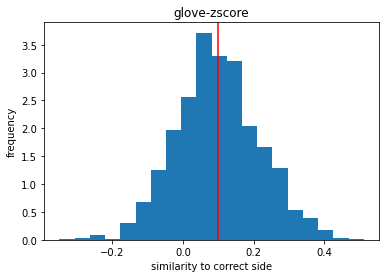

In [413]:
scores0 = plot_axes_quality('glove-zscore')

BEST [('cardinal.a.02_right', 0.46587843275706514), ('democratic.a.01_right', 0.45688202820996093), ('established.a.01_right', 0.4457313786380787), ('proved.a.01_right', 0.4400854343410742), ('diligent.a.02_left', 0.4298208091532249), ('used.a.01_left', 0.42174856144216466), ('prospective.a.01_left', 0.4127038229058156), ('partial.a.02_right', 0.3980450580154516), ('nourished.a.01_right', 0.3915070398937059), ('all.a.01_left', 0.3797426857709725)]
WORST [('leeward.a.01_left', -0.2969628124826152), ('left-handed.a.01_left', -0.27629508544904546), ('east.a.01_right', -0.2724861278640515), ('alkaline.a.01_left', -0.2609350143981471), ('western.a.02_left', -0.2469994684001294), ('right-handed.a.01_right', -0.22041623298552349), ('same.a.01_left', -0.21482705170077418), ('left-handed.a.01_right', -0.1928498721136952), ('right.a.01_right', -0.1880249658281328), ('like.a.01_left', -0.18562359995196703)]
AVG SIMILARITY TO CORRECT SIDE: 0.10148170209867674


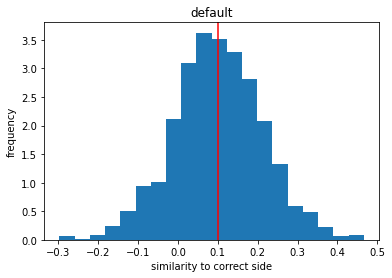

In [165]:
scores1 = plot_axes_quality('default')

BEST [('coastal.a.02_left', 0.4368380664249553), ('perfect.a.01_right', 0.4276876490635262), ('democratic.a.01_right', 0.42714771502742954), ('diligent.a.02_left', 0.42591022743403545), ('cosmopolitan.a.02_left', 0.41929372352248667), ('established.a.01_right', 0.4102471274492611), ('loyal.a.01_right', 0.4074099657427575), ('proved.a.01_right', 0.39257285403055947), ('diversified.a.01_left', 0.39057880322805066), ('mitigated.a.01_left', 0.37514608105111624)]
WORST [('lower-class.a.01_right', -0.2316134551583644), ('left.a.04_right', -0.20491319814158673), ('bidirectional.a.01_right', -0.19583210838399387), ('right.a.07_right', -0.19359646704819727), ('permeable.a.01_right', -0.1904021368740869), ('plausible.a.01_left', -0.189098644948643), ('right-handed.a.01_right', -0.1883303548346101), ('analytic.a.03_left', -0.1833651627472256), ('homemade.a.01_left', -0.18253034573641913), ('left-handed.a.01_left', -0.18238875183957756)]
AVG SIMILARITY TO CORRECT SIDE: 0.08704291958433


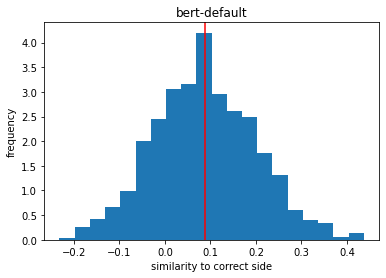

In [166]:
scores2 = plot_axes_quality('bert-default')

BEST [('established.a.01_right', 0.636359031254929), ('proved.a.01_right', 0.6069947009739739), ('coastal.a.02_left', 0.5444111445009973), ('democratic.a.01_right', 0.4940450998367891), ('diligent.a.02_left', 0.4832999204358368), ('metallic.a.01_right', 0.4729806360667726), ('intended.a.01_right', 0.46001247524519734), ('shod.a.01_right', 0.4518489139377991), ('attached.a.03_right', 0.45036379151797984), ('competent.a.01_right', 0.4463912399305633)]
WORST [('permeable.a.01_right', -0.2705601752339429), ('lower-class.a.01_right', -0.2620912966480911), ('right.a.01_right', -0.25037185741265783), ('analytic.a.03_left', -0.24327333916973268), ('digestible.a.01_left', -0.23355270547060525), ('centralizing.a.01_left', -0.22903649341725166), ('right-handed.a.01_right', -0.22704955655602474), ('bidirectional.a.01_right', -0.22493045615722074), ('right.a.07_right', -0.20999054116734406), ('simple.a.06_right', -0.20896867528317856)]
AVG SIMILARITY TO CORRECT SIDE: 0.11199743409278787


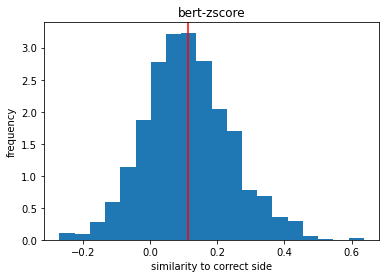

In [167]:
scores3 = plot_axes_quality('bert-zscore')

BEST [('assisted.a.01_left', 0.5327233324568565), ('democratic.a.01_right', 0.48314626517595566), ('rural.a.01_right', 0.4745505350215254), ('certain.a.02_right', 0.46775881940426245), ('coastal.a.02_left', 0.4565071632835247), ('future.a.01_left', 0.43953360280814907), ('specialized.a.01_right', 0.43691898026981285), ('complimentary.a.01_left', 0.4324316750865448), ('cooked.a.01_left', 0.43149409356962315), ('quiet.a.02_right', 0.41756053851095015)]
WORST [('homosexual.a.01_right', -0.2257058346241847), ('cooked.a.01_right', -0.22295638848041582), ('simple.a.06_right', -0.21018026697703546), ('lower-class.a.01_right', -0.2031483662722849), ('bidirectional.a.01_right', -0.19583210838399387), ('trustful.a.01_left', -0.19368569161999838), ('permeable.a.01_right', -0.1904021368740869), ('digestible.a.01_left', -0.18029774002567178), ('tidy.a.01_left', -0.17267687412646054), ('exact.a.01_right', -0.17253525104368947)]
AVG SIMILARITY TO CORRECT SIDE: 0.09114225765529424


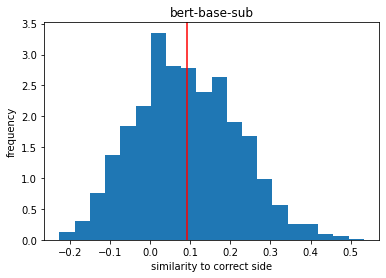

In [422]:
scores4 = plot_axes_quality('bert-base-sub')

BEST [('established.a.01_right', 0.6078804717238667), ('certain.a.02_right', 0.5914542340837428), ('proved.a.01_right', 0.5708034322401132), ('specialized.a.01_right', 0.5384322721678417), ('rural.a.01_right', 0.5309303157402877), ('tolerable.a.01_left', 0.525591955977725), ('coastal.a.02_left', 0.5152229968470149), ('complimentary.a.01_left', 0.49487367033383123), ('democratic.a.01_right', 0.4893213797685938), ('interesting.a.01_left', 0.48322091920077864)]
WORST [('permeable.a.01_right', -0.2705601752339429), ('homosexual.a.01_right', -0.2692241373654839), ('simple.a.06_right', -0.2524428322339026), ('lower-class.a.01_right', -0.24870724366063604), ('alkaline.a.01_left', -0.2425394521504315), ('centralizing.a.01_left', -0.22903649341725166), ('bidirectional.a.01_right', -0.22493045615722074), ('stressed.a.02_right', -0.21108812966578983), ('left.a.04_right', -0.19689151258349502), ('digestible.a.01_left', -0.1940071290263018)]
AVG SIMILARITY TO CORRECT SIDE: 0.11378734084380186


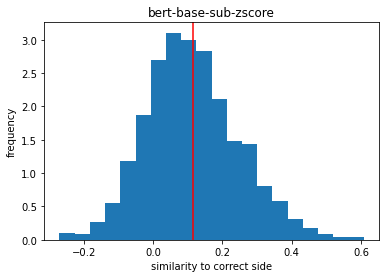

In [423]:
scores5 = plot_axes_quality('bert-base-sub-zscore')

BEST [('intellectual.a.02_left', 0.7736821048804584), ('ready.a.01_left', 0.7667368763895883), ('gracious.a.01_left', 0.7580105727797596), ('healthful.a.01_left', 0.753824827030452), ('rhetorical.a.02_left', 0.7477573550622412), ('conclusive.a.01_left', 0.7469388946043153), ('thinkable.a.01_right', 0.7437845450284777), ('corrupt.a.01_left', 0.7405056774743524), ('additive.a.02_left', 0.7360561807362979), ('serviceable.a.01_left', 0.7345996124440837)]
WORST [('intelligent.a.01_left', -0.4436716672611707), ('exact.a.01_right', -0.4391145513011482), ('north.a.01_left', -0.43817952217696843), ('conventional.a.04_left', -0.41157845004312754), ('hard.a.03_left', -0.3890352390213625), ('moderate.a.01_left', -0.3743192166060241), ('democratic.a.01_left', -0.37200301707681704), ('central.a.02_left', -0.36675983818179086), ('northern.a.04_left', -0.3612719163883658), ('heavenly.a.03_right', -0.35742899175992476)]
AVG SIMILARITY TO CORRECT SIDE: 0.09045991543478264


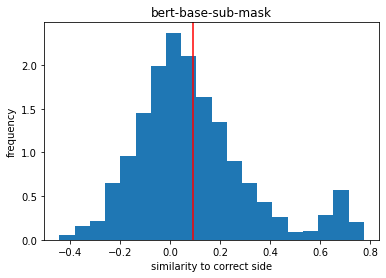

In [421]:
scores6 = plot_axes_quality('bert-base-sub-mask')

BEST [('rural.a.01_right', 0.537118127650585), ('supported.a.01_left', 0.5040856697113334), ('neutral.a.04_left', 0.4758780803178785), ('diligent.a.02_left', 0.45825617188877127), ('free.a.02_right', 0.44856743207687344), ('altered.a.01_left', 0.4378228556549071), ('democratic.a.01_right', 0.4264018423610463), ('coastal.a.02_left', 0.42425361124382244), ('perfect.a.01_right', 0.42023356337569745), ('homemade.a.01_right', 0.41975791674867646)]
WORST [('leeward.a.01_left', -0.4201295583072303), ('middle-class.a.01_right', -0.22754660094477402), ('fast.a.03_left', -0.22590593164132136), ('left-handed.a.01_right', -0.21669846619543492), ('conclusive.a.01_right', -0.20786245509825035), ('binaural.a.01_left', -0.20629685310374105), ('perpendicular.a.01_right', -0.1961126398017065), ('bidirectional.a.01_right', -0.19583210838399387), ('permeable.a.01_right', -0.1904021368740869), ('attentive.a.01_left', -0.17943368099032145)]
AVG SIMILARITY TO CORRECT SIDE: 0.10213020931515351


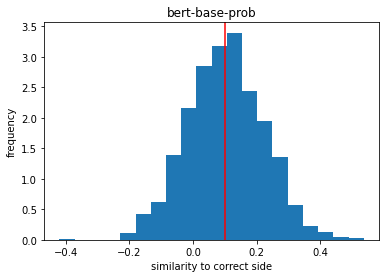

In [404]:
scores7 = plot_axes_quality('bert-base-prob')

BEST [('supported.a.01_left', 0.6833822959092323), ('rural.a.01_right', 0.639917481470154), ('free.a.02_right', 0.6175253363276528), ('established.a.01_right', 0.6067463046592594), ('neutral.a.04_left', 0.5686822206895885), ('proved.a.01_right', 0.5219600539942902), ('competent.a.01_right', 0.5196700189642048), ('diligent.a.02_left', 0.5126993172930432), ('enclosed.a.01_right', 0.5083512129991592), ('coastal.a.02_left', 0.50820548876679)]
WORST [('leeward.a.01_left', -0.45403881636601556), ('fast.a.03_left', -0.2934507718164514), ('analytic.a.03_left', -0.27760758358063103), ('permeable.a.01_right', -0.2705601752339429), ('right-handed.a.01_right', -0.25441354848997005), ('lower-class.a.01_right', -0.2447738533951932), ('binaural.a.01_left', -0.24329229826648505), ('right.a.01_right', -0.23654425383397926), ('centralizing.a.01_left', -0.22903649341725166), ('bidirectional.a.01_right', -0.22493045615722074)]
AVG SIMILARITY TO CORRECT SIDE: 0.1306419988450126


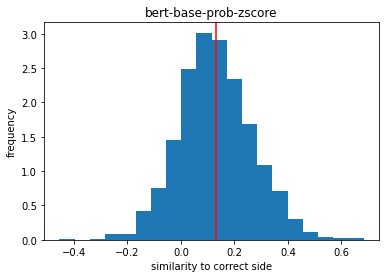

In [405]:
scores8 = plot_axes_quality('bert-base-prob-zscore')

In [426]:
# U-tests
# z-scored bert prob vs. glove
print(mannwhitneyu(list(scores8.values()), list(scores1.values())))
# z-scored bert prob vs. z-scored bert random
print(mannwhitneyu(list(scores8.values()), list(scores3.values())))
# z-scored bert substitutes vs. z-scored bert random
print(mannwhitneyu(list(scores5.values()), list(scores3.values())))
# z-scored bert random vs. glove
print(mannwhitneyu(list(scores3.values()), list(scores1.values())))

MannwhitneyuResult(statistic=921952.0, pvalue=1.889197637186775e-08)
MannwhitneyuResult(statistic=961196.0, pvalue=8.736923440638331e-05)
MannwhitneyuResult(statistic=1009212.0, pvalue=0.44578452121207457)
MannwhitneyuResult(statistic=1010294.0, pvalue=0.058653859770114364)


In [334]:
def get_num_words_per_side(): 
    # returns dictionary of synset_side : # of adj
    num_words = {}
    with open(LOGS + 'semantics_val/wordnet_axes.txt', 'r') as infile: 
        for line in infile: 
            contents = line.split('\t')
            synset = contents[0]
            axis1 = contents[1].split(',')
            num_words[synset + '_left'] = len(axis1)
            axis2 = contents[2].split(',')
            num_words[synset + '_right'] = len(axis2)
    return num_words
    
def get_num_vectors_per_side(exp_name): 
    # returns dictionary of synset_side : # of vectors
    vec_dict = get_bert_vecs(exp_name)
    if 'sub' not in exp_name: 
        num_vectors = Counter()
        for pole in axes: 
            for side_pole in [pole + '_left', pole + '_right']: 
                if 'left' in side_pole: 
                    side = axes[pole][0]
                else: 
                    side = axes[pole][1]
                for w in side: 
                    ss_adj = w + '@' + side_pole
                    if ss_adj in vec_dict:  
                        num_vectors[side_pole] += 1 
        return num_vectors
    in_folder = LOGS + 'wikipedia/substitutes/' + exp_name + '/'
    with open(in_folder + 'word_rep_key.json', 'r') as infile: 
        word_rep_keys = json.load(infile)
    num_vectors = Counter()
    for pole in axes: 
        for side_pole in [pole + '_left', pole + '_right']: 
            if 'left' in side_pole: 
                side = axes[pole][0]
            else: 
                side = axes[pole][1]
            if side_pole not in word_rep_keys:
                # fall back on bert random
                for w in side: 
                    ss_adj = w + '@' + side_pole
                    if ss_adj in vec_dict:  
                        num_vectors[side_pole] += 1 
            else: 
                rep_keys = word_rep_keys[side_pole] # [[line_num, word]]
                these_words = []
                for i, rk in enumerate(rep_keys): 
                    line_num = rk[0]
                    w = rk[1]
                    these_words.append(w)
                side_vec = np.load(in_folder + side_pole + '.npy')
                num_vectors[side_pole] = len(side_vec)
    return num_vectors
    
def get_num_polysemous_per_side(): 
    # returns dictionary of synset_side : # of polysemous words
    num_axis_per_word = Counter()
    with open(LOGS + 'semantics_val/wordnet_axes.txt', 'r') as infile: 
        for line in infile: 
            contents = line.split('\t')
            synset = contents[0]
            axis1 = contents[1].split(',')
            for w in axis1: 
                num_axis_per_word[w] += 1
            axis2 = contents[2].split(',')
            for w in axis2: 
                num_axis_per_word[w] += 1
    cutoff = 5
    polysemous_words = set()
    for w in num_axis_per_word: 
        if num_axis_per_word[w] > 10: 
            polysemous_words.add(w)
    num_words = {}
    with open(LOGS + 'semantics_val/wordnet_axes.txt', 'r') as infile: 
        for line in infile: 
            contents = line.split('\t')
            synset = contents[0]
            axis1 = contents[1].split(',')
            if set(axis1) & polysemous_words: 
                num_words[synset + '_left'] = 1
            else: 
                num_words[synset + '_left'] = 0
            axis2 = contents[2].split(',')
            if set(axis2) & polysemous_words: 
                num_words[synset + '_right'] = 1
            else: 
                num_words[synset + '_right'] = 0
    return num_words

In [309]:
num_words = get_num_words_per_side()
num_polysemous = get_num_polysemous_per_side()

In [391]:
def compare_axis_quality(scores_dict1, scores_dict2, third_dim, title):
    x = []
    y = []
    z = []
    for k in scores_dict1: 
        if k in scores_dict2: 
            x.append(scores_dict1[k])
            y.append(scores_dict2[k])
            z.append(third_dim[k])
    plt.scatter(x, y, c=z, cmap='coolwarm')
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    plt.title(title)
    plt.show()
    
def plot_polysemous(scores_dict):
    polys = []
    non_polys = []
    for k in num_polysemous: 
        if num_polysemous[k] == 0: 
            non_polys.append(scores_dict[k])
        else: 
            polys.append(scores_dict[k])
    plt.hist(non_polys)
    plt.axvline(x=np.mean(non_polys), color='blue')
    plt.hist(polys)
    plt.axvline(x=np.mean(polys), color='orange')
    plt.title("BERT default scores, polysemous vs. non-polysemous")
    plt.show()
    
def plot_num_vectors(scores_dict, num_vectors):
    many = []
    few = []
    for k in num_vectors: 
        if 'left' in k: 
            other_k = k.replace('_left', '_right')
        else: 
            other_k = k.replace('_right', '_left')
        total = num_vectors[k] + num_vectors[other_k]
        if total > 100: 
            many.append(scores_dict[k])
        else: 
            few.append(scores_dict[k])
    plt.hist(many, alpha=0.5)
    plt.axvline(x=np.mean(many), color='blue')
    plt.hist(few, alpha=0.5)
    plt.axvline(x=np.mean(few), color='orange')
    plt.title("many vectors vs. few vectors")
    plt.show()

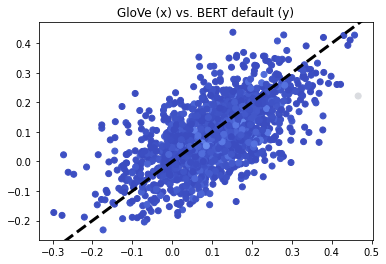

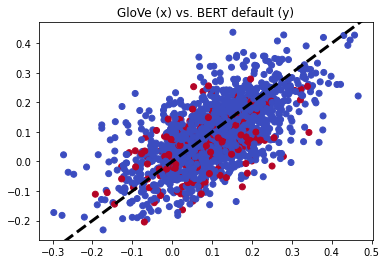

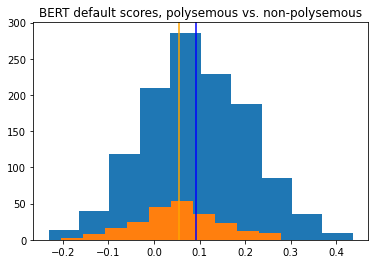

In [392]:
compare_axis_quality(scores1, scores2, num_words, 'GloVe (x) vs. BERT default (y)')
compare_axis_quality(scores1, scores2, num_polysemous, 'GloVe (x) vs. BERT default (y)')
plot_polysemous(scores2)

In [393]:
num_vectors = get_num_vectors_per_side('bert-base-sub')

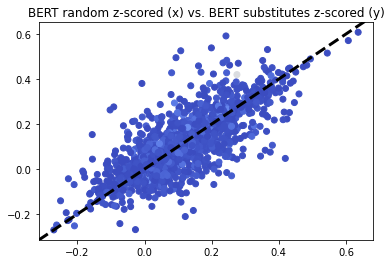

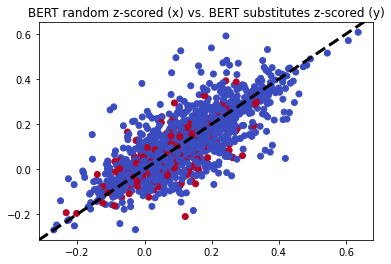

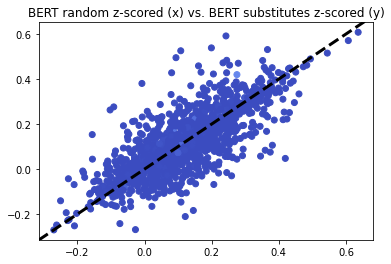

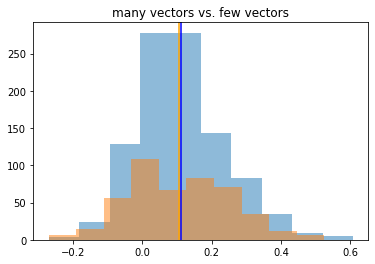

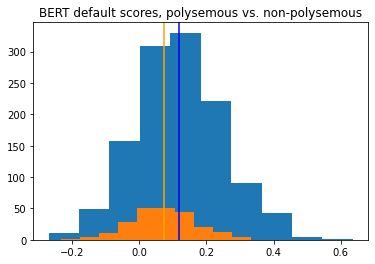

In [394]:
compare_axis_quality(scores3, scores5, num_words, 'BERT random z-scored (x) vs. BERT substitutes z-scored (y)')
compare_axis_quality(scores3, scores5, num_polysemous, 'BERT random z-scored (x) vs. BERT substitutes z-scored (y)')
compare_axis_quality(scores3, scores5, num_vectors, 'BERT random z-scored (x) vs. BERT substitutes z-scored (y)')
plot_num_vectors(scores5, num_vectors)
plot_polysemous(scores3)

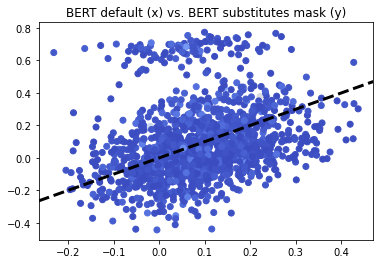

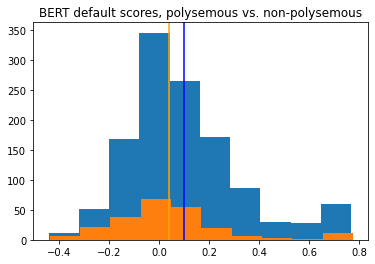

In [397]:
compare_axis_quality(scores2, scores6, num_words, 'BERT default (x) vs. BERT substitutes mask (y)')
plot_polysemous(scores6)

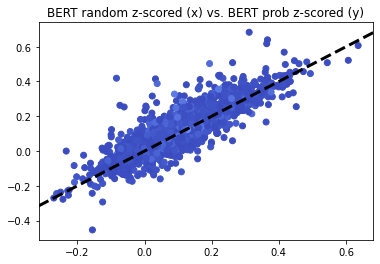

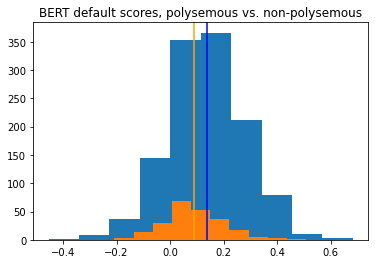

In [406]:
compare_axis_quality(scores3, scores8, num_words, 'BERT random z-scored (x) vs. BERT prob z-scored (y)')
plot_polysemous(scores8)

Investigate the reason behind the better performance when substitutes are masked. 

In [200]:
unusual = defaultdict(list)
for k in scores6: 
    if scores6[k] > 0.6 and scores4[k] < 0.3: 
        contents = k.split('_')
        synset = contents[0]
        side = contents[1]
        unusual[synset].append(side)
with open(LOGS + 'semantics_val/wordnet_axes.txt', 'r') as infile: 
    for line in infile: 
        contents = line.split('\t')
        if contents[0] in unusual: 
            print(contents[0], unusual[contents[0]])
            print(line)

abridged.a.01 ['left']
abridged.a.01	abridged,cut,half-length,potted,shortened	full-length,unabridged,uncut

additive.a.02 ['left']
additive.a.02	accumulative,additional,additive,complementary,completing,cumulative,extra,incremental,intercalary,summative,supplemental,supplementary	ablative,reductive,subtractive

adroit.a.01 ['left']
adroit.a.01	adroit,clean,clever,co-ordinated,coordinated,cunning,deft,dexterous,dextrous,handy,ingenious,neat,quick-witted	bumbling,bungling,handless,heavy-handed,inept,left-handed,maladroit,tactless,uncoordinated

aggressive.a.01 ['left']
aggressive.a.01	aggressive,bellicose,combative,competitive,hard-hitting,high-pressure,hostile,in-your-face,militant,obstreperous,predatory,pugnacious,rapacious,raptorial,ravening,rough,scrappy,truculent	low-pressure,nonaggressive,unaggressive

alienable.a.01 ['right']
alienable.a.01	alienable,assignable,negotiable,transferable,transferrable	absolute,inalienable,inviolable,non-negotiable,unalienable

armed.a.03 ['left']
ar

In [411]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None,
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])

    return texts

def get_side_pole_rep(side, in_folder, vec_dict, both_vec, words, side_pole, word_rep_keys): 
    if side_pole not in word_rep_keys:
        print("Falling back on bert random for", side)
        # fall back on bert random
        for w in side: 
            ss_adj = w + '@' + side_pole
            if ss_adj in vec_dict:  
                both_vec.append(vec_dict[ss_adj])
                words.append(w)   
    else: 
        rep_keys = word_rep_keys[side_pole] # [[line_num, word]]
        these_words = []
        for i, rk in enumerate(rep_keys): 
            line_num = rk[0]
            w = rk[1]
            these_words.append(w)
        side_vec = np.load(in_folder + side_pole + '.npy')
        if 'zscore' in exp_name: 
            bert_mean = np.load(LOGS + 'wikipedia/mean_BERT.npy')
            bert_std = np.load(LOGS + 'wikipedia/std_BERT.npy')
            side_vec = (side_vec - bert_mean) / bert_std
        single_vec_per_word = defaultdict(list)
        for i, row in enumerate(side_vec): 
            w = these_words[i]
            single_vec_per_word[w].append(side_vec[i])
        # aggregate reps for each word
        for w in sorted(single_vec_per_word.keys()): 
            words.append(w)
            both_vec.append(np.mean(single_vec_per_word[w], axis=0))
    return both_vec, words

def generate_heatmap(pole, vec_dict, axes, exp_name): 
    if 'sub' in exp_name: 
        if 'mask' not in exp_name: 
            in_folder = LOGS + 'wikipedia/substitutes/bert-base-sub/'
        elif 'mask' in exp_name: 
            in_folder = LOGS + 'wikipedia/substitutes/bert-base-sub-mask/'
        else: 
            in_folder = LOGS + 'wikipedia/substitutes/' + exp_name + '/'
        with open(in_folder + 'word_rep_key.json', 'r') as infile: 
            word_rep_keys = json.load(infile)
        both_vec = []
        words = []
        print("Getting side pole rep...")
        left = axes[pole][0]
        right = axes[pole][1]
        both_vec, words = get_side_pole_rep(left, in_folder, vec_dict, both_vec, words, 
                                            pole + '_left', word_rep_keys)
        both_vec, words = get_side_pole_rep(right, in_folder, vec_dict, both_vec, words, 
                                            pole + '_right', word_rep_keys)
    else: 
        left = axes[pole][0]
        both_vec = []
        words = []
        for w in left: 
            k = w+'@'+pole+'_left'
            if k in vec_dict: 
                words.append(w)
                both_vec.append(vec_dict[k])

        right = axes[pole][1]
        for w in right: 
            k = w+'@'+pole+'_right'
            if k in vec_dict: 
                words.append(w)
                both_vec.append(vec_dict[k])
        both_vec = np.array(both_vec)
    
    sim = cosine_similarity(both_vec)
    fig, ax = plt.subplots()

    im, cbar = heatmap(sim, words, words, ax=ax, 
                       cmap="YlGn", cbarlabel="similarity")
    texts = annotate_heatmap(im)

    fig.tight_layout()
    plt.show()

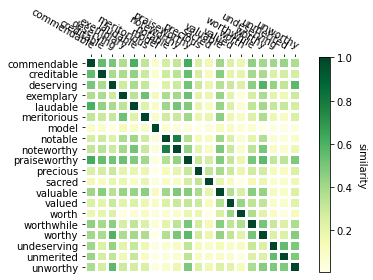

In [231]:
exp_name = 'bert-zscore'
bert_vecs = get_bert_vecs(exp_name)
generate_heatmap('worthy.a.01', bert_vecs, axes, exp_name)

Getting side pole rep...
Falling back on bert random for ['undeserving', 'unmerited', 'unworthy']


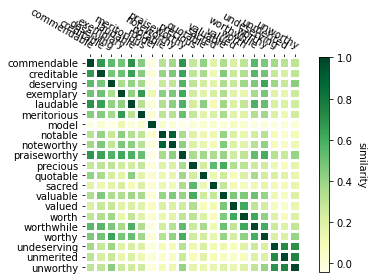

In [357]:
exp_name = 'bert-base-sub-zscore'
bert_vecs = get_bert_vecs(exp_name)
generate_heatmap('worthy.a.01', bert_vecs, axes, exp_name)

Getting side pole rep...
Falling back on bert random for ['undeserving', 'unmerited', 'unworthy']


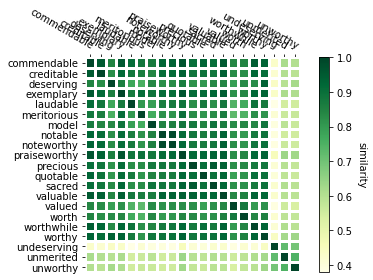

In [255]:
exp_name = 'bert-base-sub-mask'
bert_vecs = get_bert_vecs(exp_name)
generate_heatmap('worthy.a.01', bert_vecs, axes, exp_name)

Getting side pole rep...
Falling back on bert random for ['unappealing', 'unlikable', 'unlikeable', 'unsympathetic']


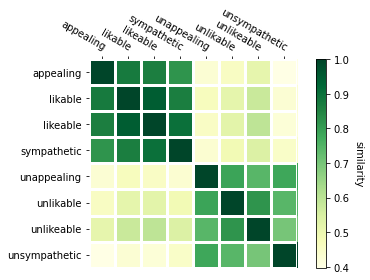

In [256]:
exp_name = 'bert-base-sub-mask'
bert_vecs = get_bert_vecs(exp_name)
generate_heatmap('sympathetic.a.04', bert_vecs, axes, exp_name)

Getting side pole rep...
Falling back on bert random for ['dissident', 'heretical', 'heterodox', 'iconoclastic', 'nonconforming', 'nonconformist', 'recusant', 'unorthodox']


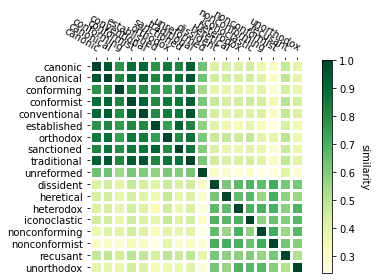

In [257]:
exp_name = 'bert-base-sub-mask'
bert_vecs = get_bert_vecs(exp_name)
generate_heatmap('orthodox.a.02', bert_vecs, axes, exp_name)

Getting side pole rep...


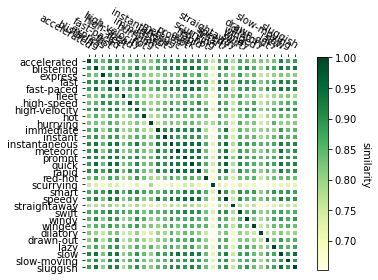

In [380]:
exp_name = 'bert-base-sub-mask'
bert_vecs = get_bert_vecs(exp_name)
generate_heatmap('fast.a.01', bert_vecs, axes, exp_name)

Getting side pole rep...


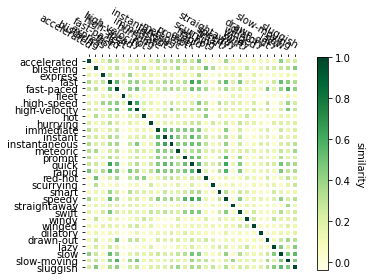

In [384]:
exp_name = 'bert-base-sub-zscore'
bert_vecs = get_bert_vecs(exp_name)
generate_heatmap('fast.a.01', bert_vecs, axes, exp_name)

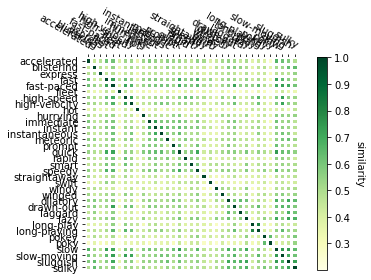

In [386]:
exp_name = 'bert-base-zscore'
bert_vecs = get_bert_vecs(exp_name)
generate_heatmap('fast.a.01', bert_vecs, axes, exp_name)

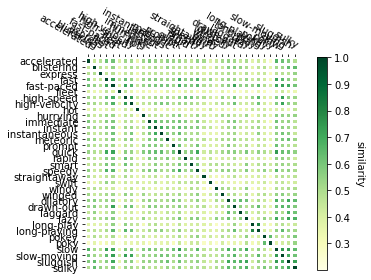

In [408]:
exp_name = 'bert-base-prob-zscore'
bert_vecs = get_bert_vecs(exp_name)
generate_heatmap('fast.a.01', bert_vecs, axes, exp_name)